# ECE 183/293 - Brain-Inspired Machine Learning
# Week 1 Tutorial: Neural Networks
### Written by Jason Eshraghian

What you will learn:
* MNIST classification with a fully-connected network (FCN)
* MNIST classification with a convolutional neural network (CNN)
* CIFAR-10 classification with a CNN

## 1. Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

## 2. Training a FCN on MNIST
Let's train a FCN on the MNIST dataset. The goal is to train a model to be able to classify the handwritten digits dataset, which has 10-classes in it.

If there are lines of code you don't understand, then copy-paste them into ChatGPT and query what they do.

### 2.1 Download the MNIST Dataset

In [3]:
# MNIST dataset and dataloader

# Define transformation to MNIST
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download dataset and apply transformations
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)

# Create iterable dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

2.0%

100.0%


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw


100.0%

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



100.0%
100.0%


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



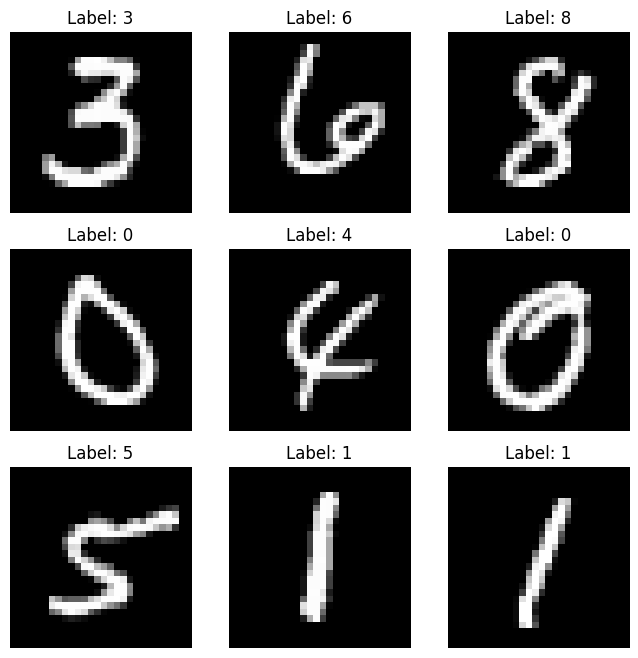

In [4]:
# Visualize some MNIST samples
def visualize_mnist_samples():
    data_iter = iter(train_loader)
    images, labels = data_iter.__next__()
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze().numpy(), cmap='gray')
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
    plt.show()

visualize_mnist_samples()

In [5]:
# Get a single mini-batch and print its size
data_iter = iter(train_loader)
images, labels = data_iter.__next__()

print(f"Size of images mini-batch: {images.size()}")
print(f"Size of labels mini-batch: {labels.size()}")

Size of images mini-batch: torch.Size([64, 1, 28, 28])
Size of labels mini-batch: torch.Size([64])


One of the most common errors you'll run into are "shape" / "size" errors. I.e., the size of your layers and/or datasets don't match up. It's often really useful to query the size of your images and activations in your model.

You should see the following:
* 64: batch-size
* 1: channel size (i.e., black and white. An RGB image should have 3 channels)
* 28 x 28: x & y-dimensions

### 2.2 Define Model
In the lectures, we used ``nn.Sequential(...)`` to define a model.
The following is an alternative method that is more verbose, but allows for better customization and flexibility. I almost always will wrap my model in a class that inherits the attributes of `nn.Module`. Some notes:

* The model has 28*28 inputs, a 500-neuron hidden layer, and 10 outputs
* We will use a ReLU activation in the hidden layer
* The functions in `__init__` are all initialized when `FCN` is first instantiated within `model` (bottom line)
* The functions in `forward` are called when data is passed to `model`

In [19]:
# Fully-connected network
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(28*28, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = x.flatten(1) # flatten 1 x 28 x 28 --> 784 for FCN compatibility
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = FCN().to(device)

cuda


Note: `device` is set to `"cuda"` automatically if a GPU is available. Otherwise, it will use CPU. If you wish to take advantage of limited free GPU hours on Google Colab, then click Runtime >> Change Runtime Type >> GPU.

GPUs will significantly speed up training times over CPUs as they're built for parallel workloads.

### 2.3 Define Hyperparameters

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 2.3 Training Loop

Epoch [1/5], Step [100/938], Loss: 0.4998
Epoch [1/5], Step [200/938], Loss: 0.4359
Epoch [1/5], Step [300/938], Loss: 0.1778
Epoch [1/5], Step [400/938], Loss: 0.1847
Epoch [1/5], Step [500/938], Loss: 0.2349
Epoch [1/5], Step [600/938], Loss: 0.2692
Epoch [1/5], Step [700/938], Loss: 0.1650
Epoch [1/5], Step [800/938], Loss: 0.0708
Epoch [1/5], Step [900/938], Loss: 0.4573
Epoch [2/5], Step [100/938], Loss: 0.1078
Epoch [2/5], Step [200/938], Loss: 0.1266
Epoch [2/5], Step [300/938], Loss: 0.0614
Epoch [2/5], Step [400/938], Loss: 0.3494
Epoch [2/5], Step [500/938], Loss: 0.0560
Epoch [2/5], Step [600/938], Loss: 0.0804
Epoch [2/5], Step [700/938], Loss: 0.0607
Epoch [2/5], Step [800/938], Loss: 0.0984
Epoch [2/5], Step [900/938], Loss: 0.1665
Epoch [3/5], Step [100/938], Loss: 0.1022
Epoch [3/5], Step [200/938], Loss: 0.0549
Epoch [3/5], Step [300/938], Loss: 0.0449
Epoch [3/5], Step [400/938], Loss: 0.0963
Epoch [3/5], Step [500/938], Loss: 0.0541
Epoch [3/5], Step [600/938], Loss:

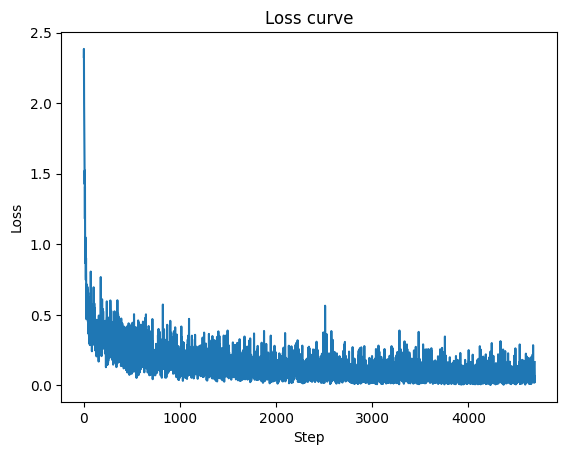

In [8]:
# Train the model

def train_model(model, train_loader, optimizer, criterion, num_epochs=5):
    model.train()
    loss_list = []
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")
    # Plot loss curve
    plt.plot(loss_list)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss curve')
    plt.show()

train_model(model, train_loader, optimizer, criterion)

Hopefully your training loss curve reduces with training iterations / steps. It'll be noisy, but that's expected because each step is passing a different data sample (i.e., "stochastic" gradient descent).

### 2.4 Model Evaluation

We will evaluate the accuracy on the test set. See if you can rewrite the function call to use the train set instead.

In [9]:
# Evaluate the model on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the model on the test images: {100 * correct / total} %')

evaluate_model(model, test_loader)

Accuracy of the model on the test images: 97.09 %


Fuck yeah.

As a hella fun exercise, try reinitializing the model and checking its accuracy before training. It'll probably suck.

## 3. MNIST + Convolutional Neural Networks

Convolutional Neural Networks (CNNs) are specifically tailored for images. These are a de facto standard type of model for doing anything with images, videos, and things with spatial information. I strongly recommend learning the basics if you're not already familiar.

* StatQuest with Josh Starmer ([YouTube](https://www.youtube.com/watch?v=HGwBXDKFk9I))
* "But what is a convolution?" by 3Blue1Brown ([YouTube](https://www.youtube.com/watch?v=KuXjwB4LzSA))
* A full playlist by deeplearning.ai / Andrew Ng ([YouTube](https://www.youtube.com/playlist?list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF))

Note: the CNN model here has far more computational steps than the FCN. Using a GPU would be useful, or otherwise, reducing the number of epochs in your training loop to speed things up.

### 3.1 Define Model

In [10]:
### 2. Convolutional Neural Network on MNIST

class CNN_MNIST(nn.Module):
    def __init__(self):
        super(CNN_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 6 * 6, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x))) # note: no need to flatten the image this time. CNNs expect 3-D data (C x X x Y).
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_cnn = CNN_MNIST().to(device)

### 3.2 Define Hyperparameters

In [11]:
optimizer_cnn = optim.Adam(model_cnn.parameters(), lr=0.001)

### 3.3 Run Training Loop
We already wrote a training loop earlier on that we can reuse with our new CNN.

Epoch [1/5], Step [100/938], Loss: 0.1715
Epoch [1/5], Step [200/938], Loss: 0.0831
Epoch [1/5], Step [300/938], Loss: 0.0269
Epoch [1/5], Step [400/938], Loss: 0.2583
Epoch [1/5], Step [500/938], Loss: 0.0088
Epoch [1/5], Step [600/938], Loss: 0.1315
Epoch [1/5], Step [700/938], Loss: 0.0106
Epoch [1/5], Step [800/938], Loss: 0.0247
Epoch [1/5], Step [900/938], Loss: 0.0123
Epoch [2/5], Step [100/938], Loss: 0.0387
Epoch [2/5], Step [200/938], Loss: 0.1266
Epoch [2/5], Step [300/938], Loss: 0.0358
Epoch [2/5], Step [400/938], Loss: 0.0617
Epoch [2/5], Step [500/938], Loss: 0.0222
Epoch [2/5], Step [600/938], Loss: 0.0052
Epoch [2/5], Step [700/938], Loss: 0.0223
Epoch [2/5], Step [800/938], Loss: 0.0291
Epoch [2/5], Step [900/938], Loss: 0.0140
Epoch [3/5], Step [100/938], Loss: 0.0676
Epoch [3/5], Step [200/938], Loss: 0.0012
Epoch [3/5], Step [300/938], Loss: 0.0269
Epoch [3/5], Step [400/938], Loss: 0.0662
Epoch [3/5], Step [500/938], Loss: 0.0017
Epoch [3/5], Step [600/938], Loss:

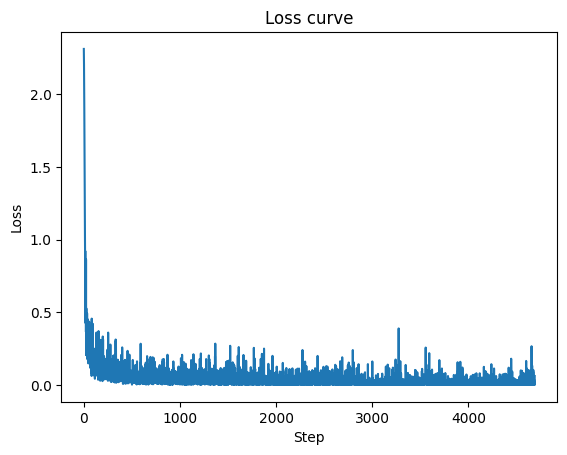

In [12]:
train_model(model_cnn, train_loader, optimizer_cnn, criterion)

### 3.4 Evaluate on test set

In [13]:
evaluate_model(model_cnn, test_loader)

Accuracy of the model on the test images: 98.96 %


Wawaweeeewa very nice

## 4. Train on CIFAR-10

So MNIST is pretty easy to solve. We tend to stay away from it in research papers, because at this point, there are loads of models that achieve >99% on the test set, and any differences are kinda meaningless and usually a result of randomness.

So CIFAR-10 is a more challenging, RGB dataset that might take a little longer to train.

It also has different dimensions to MNIST. So you'll see how a convolutional neural network must be changed in size to adapt to differently sized data.

## 4.1 Download Dataset

In [14]:
# 1. CIFAR-10 dataset and dataloader
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-10 Dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

# Construct dataloaders
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's visualize some samples.

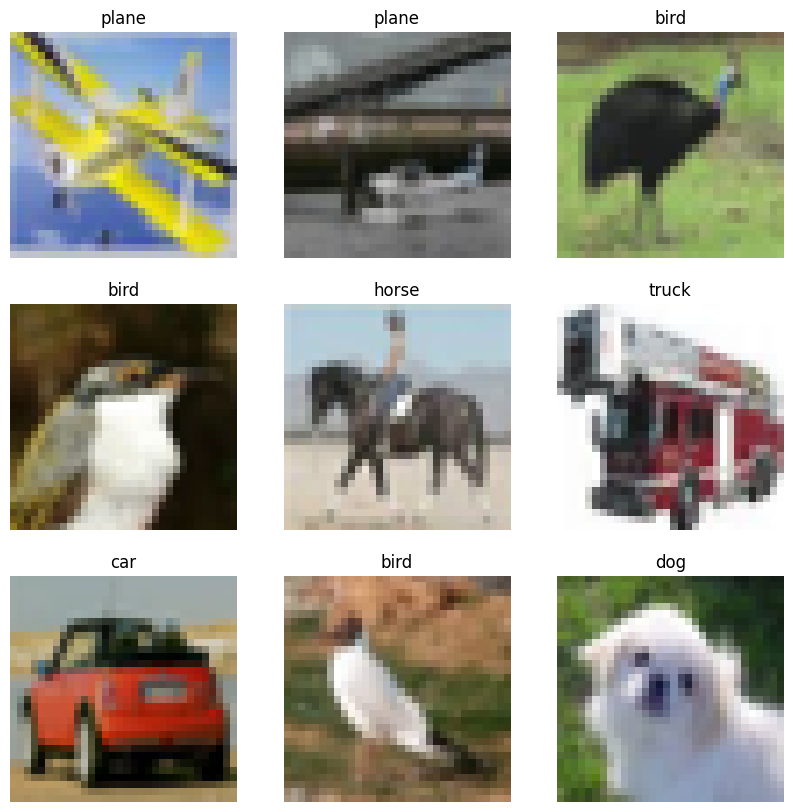

In [15]:
def visualize_cifar10_samples(loader):
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    # Get a batch of training images
    data_iter = iter(loader)
    images, labels = data_iter.__next__()

    # Plot the images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        image = images[i] / 2 + 0.5  # Unnormalize
        image = image.numpy().transpose((1, 2, 0))
        ax.imshow(image)
        ax.set_title(classes[labels[i]])
        ax.axis('off')
    plt.show()

visualize_cifar10_samples(train_loader)

Shot on Samsung Galaxy S20, probably.

### 4.2 Construct Model

In [16]:
# Convolutional Neural Network
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super(CIFAR_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*8*8, 512)
        self.fc2 = nn.Linear(512, 10)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*8*8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = CIFAR_CNN().to(device)

### 4.3 Define hyperparameters

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 4.4 Training Loop
This training loop might take a while. A GPU will help. Otherwise, consider reducing the number of epochs.

Epoch [1/10], Avg Loss: 1.2818
Epoch [1/10], Test Accuracy: 63.75%
Epoch [2/10], Avg Loss: 0.8989
Epoch [2/10], Test Accuracy: 69.59%
Epoch [3/10], Avg Loss: 0.7059
Epoch [3/10], Test Accuracy: 70.46%
Epoch [4/10], Avg Loss: 0.5471
Epoch [4/10], Test Accuracy: 71.56%
Epoch [5/10], Avg Loss: 0.3882
Epoch [5/10], Test Accuracy: 73.71%
Epoch [6/10], Avg Loss: 0.2535
Epoch [6/10], Test Accuracy: 72.49%
Epoch [7/10], Avg Loss: 0.1523
Epoch [7/10], Test Accuracy: 73.16%
Epoch [8/10], Avg Loss: 0.0984
Epoch [8/10], Test Accuracy: 71.49%
Epoch [9/10], Avg Loss: 0.0778
Epoch [9/10], Test Accuracy: 72.52%
Epoch [10/10], Avg Loss: 0.0741
Epoch [10/10], Test Accuracy: 72.52%


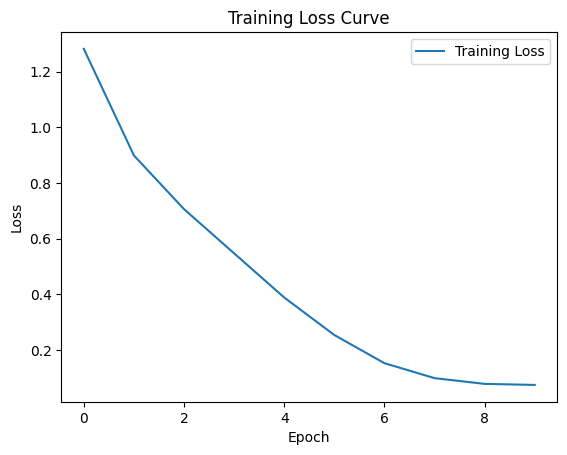

In [18]:
# ... [other parts of the code remain unchanged]

# 3. Train the model
def train_model(model, train_loader, test_loader, optimizer, criterion, num_epochs=10):
    train_loss_history = []  # Store average training loss for each epoch

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_batches = len(train_loader)

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradient buffers
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights

            running_loss += loss.item()

        avg_train_loss = running_loss / total_batches
        train_loss_history.append(avg_train_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Avg Loss: {avg_train_loss:.4f}")

        # Optional: Evaluate on test set every epoch
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Test Accuracy: {100 * correct / total}%')

    # Plot training loss
    plt.plot(train_loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

train_model(model, train_loader, test_loader, optimizer, criterion)

Congratulations. You did it! I'm proud of you.